In [210]:
## ignore this code, just used for submission

#Update your token
STUDENT_TOKEN = 'EUGENIOMARCHIORI'

import requests
import pprint
import json
import random
import time
from copy import copy, deepcopy

class Game:
  def __init__(self, state, status, player):
    self.state = state
    self.status = status
    self.player = player

  def is_waiting(self):
    return self.status == 'waiting'

  def is_end(self):
    return self.status == 'complete'

  def get_board(self):
    return json.loads(self.state)

  def actions(self):
    return []

  def print_game(self):
    print(self.state)

def new_game(game_type, multi_player = False):
  for _ in range(10):
    r = requests.get('https://emarchiori.eu.pythonanywhere.com/new-game?TOKEN=%s&game-type=%s&multi-player=%s' % (STUDENT_TOKEN, game_type, 'True' if multi_player else 'False'))
    if r.status_code == 200:
      return r.json()['game-id']
    print(r.content)

def join_game(game_type, game_id):
  for _ in range(10):
    r = requests.get('https://emarchiori.eu.pythonanywhere.com/join-game?TOKEN=%s&game-type=%s&game-id=%s' % (STUDENT_TOKEN, game_type, game_id))
    if r.status_code == 200:
      return r.json()['player']
    print(r.content)

def game_state(game_type, game_id, GameClass):
  for _ in range(10):
    r = requests.get('https://emarchiori.eu.pythonanywhere.com/game-state?TOKEN=%s&game-type=%s&game-id=%s' % (STUDENT_TOKEN, game_type, game_id))
    if r.status_code == 200:
      return GameClass(r.json()['state'], r.json()['status'], r.json()['player'])
    print(r.content)

def update_game(game_type, game_id, player, move):
  for _ in range(10):
    r = requests.get('https://emarchiori.eu.pythonanywhere.com/update-game?TOKEN=%s&game-type=%s&game-id=%s&player=%s&move=%s' % (STUDENT_TOKEN, game_type, game_id, player, move))
    if r.status_code == 200:
      return r.content
    print(r.content)

def game_loop(solver, GameClass, game_type, multi_player = False, id = None):
    while True:
        if id is None:
            print('\033[92mCreating new game...\033[0m')
            id = new_game(game_type, multi_player)

        print('\033[92mJoining game with id: %s\033[0m' % id)
        player = join_game(game_type, id)

        if player != 'X':
            #print('\033[91mNot player X, restarting...\033[0m')
            id = None  # Reset the game id to create a new game
            continue   # Restart the game creation process

        print('\033[92mPlaying as %s\033[0m' % player)

        game = game_state(game_type, id, GameClass)
        print('\033[91mWaiting for the other player to join...\033[0m')
        while game.is_waiting():
            time.sleep(10)
            game = game_state(game_type, id, GameClass)

        while True:
            game = game_state(game_type, id, GameClass)
            if game is None:
                print("Failed to fetch the game state.")
                break  # Exit the loop if the game state couldn't be fetched

            game.print_game()
            if game.is_end():
                if game.player == '-':
                    print('\033[94mdraw\033[0m')
                else:
                    print('\033[92mwinner\033[0m' if game.player == player else '\033[91mloser\033[0m')
                return
            if game.player == player:
                print('Making next move...')
                move = solver(game)
                update_result = update_game(game_type, id, player, json.dumps(move))
                print(update_result)
            else:
                time.sleep(2)


## Monte Carlo Tree Search (MCTS) for Checkers

This implementation includes an advanced Monte Carlo Tree Search (MCTS) algorithm tailored for the game of Checkers. It encompasses several key components: MCTS with UCB1 for node selection, dominance-based early stopping, tile count heuristic for game evaluation, and the Old Faithful opening move strategy.

### Key Components of the Implementation

1. **MCTSNode Class**: Represents a node in the MCTS tree. Each node contains the game state, parent node, possible moves from the current state, and statistics for the number of wins and visits, crucial for the MCTS algorithm.

2. **UCB1 for Node Selection**: Implements the Upper Confidence Bound 1 (UCB1) algorithm for selecting a child node during the Selection phase of MCTS. UCB1 balances exploration of less visited nodes and exploitation of nodes known to be promising.

3. **Old Faithful Opening Move**: A predefined optimal move for the initial state of the game. If the game is in its initial configuration, the algorithm will choose this move, speeding up the decision process.

4. **Dominance-Based Early Stopping**: During the Simulation phase, if a move significantly improves the player's position (defined as a 2-piece advantage change), the simulation terminates early. This approach focuses on quickly capitalizing on advantageous situations.

5. **Tile Count Heuristic**: A heuristic evaluation based on the difference in the number of pieces between players. It's used to estimate the game state's favorability for the player.

6. **Monte Carlo Tree Search Solver (mcts_solver)**: The main function that orchestrates the MCTS process. It performs iterations of the MCTS algorithm, each consisting of four phases: Selection, Expansion, Simulation, and Backpropagation. The function returns the move associated with the most visited node after all iterations, indicating the best-found move.

### Function Descriptions

- `mcts_solver`: The primary function to execute the MCTS algorithm, handling the logic for each phase of MCTS.
- `simulate_game`: Simulates a game from the current state to its conclusion, using random moves, dominance checking, and the heuristic evaluation.
- `is_dominant_position`: Checks if the current player's position is dominant enough to warrant early termination of the simulation.
- `piece_count_heuristic`: Provides a heuristic score based on the difference in the number of pieces between the two players.
- `old_faithful_move`: Determines if the Old Faithful move is applicable for the current game state.
- `is_initial_board_state`: Checks if the game is in its initial board configuration.

This comprehensive MCTS implementation is designed to effectively balance between exploring new strategies and exploiting known advantageous paths, making it well-suited for complex strategic games like Checkers.


In [211]:
import math
import random
from copy import deepcopy

class MCTSNode:
    def __init__(self, state, parent=None, move=None):
        # Initialize a node in the MCTS tree with the given state.
        # 'parent' is the parent node, 'move' is the move that led to this state.
        self.state = state
        self.parent = parent
        self.move = move
        self.children = []
        self.wins = 0
        self.visits = 0
        self.untried_actions = self.untried_moves()

    def untried_moves(self):
         # Return the list of possible actions (moves) from this state.
        return self.state.actions()

    def is_terminal_node(self):
        # Check if the node represents a terminal state (end of the game).
        return self.state.is_end()

    def select_child(self):
        """ 
        Select a child node with the highest UCB1 value. 
        UCB1 (Upper Confidence Bound 1) balances exploration and exploitation.
        """
        ucb1_values = [(child.wins / child.visits) + 2 * (2 * math.log(self.visits) / child.visits) ** 0.5 for child in self.children]
        return self.children[ucb1_values.index(max(ucb1_values))]

    def add_child(self, move, state):
       
        """
        Add a new child node for this move. 
        'move' leads to the given 'state'. The new node is appended to children.
        """        
        child_node = MCTSNode(state=state, parent=self, move=move)
        self.untried_actions.remove(move)
        self.children.append(child_node)
        return child_node

    def update(self, result):
        """
        Update this node - one additional visit (to keep track on num simulations) and result additional wins. 
        """
        self.visits += 1
        self.wins += result

def is_initial_board_state(game):
    initial_board_state = [
        ['_', 'x', '_', 'x', '_', 'x', '_', 'x'],
        ['x', '_', 'x', '_', 'x', '_', 'x', '_'],
        ['_', 'x', '_', 'x', '_', 'x', '_', 'x'],
        ['_', '_', '_', '_', '_', '_', '_', '_'],
        ['_', '_', '_', '_', '_', '_', '_', '_'],
        ['o', '_', 'o', '_', 'o', '_', 'o', '_'],
        ['_', 'o', '_', 'o', '_', 'o', '_', 'o'],
        ['o', '_', 'o', '_', 'o', '_', 'o', '_']
    ]
    return game.get_board() == initial_board_state

def old_faithful_move(player, game):
    """
    Return the "Old Faithful" move for the player, if applicable.
    This is a predefined optimal move for the initial state.
    """
    if player == 'X' and game.player == 'X':
        return (2, 5, 3, 4)  # "Old Faithful" move for 'X' player
    elif player == 'O' and game.player == 'O':
        return (5, 2, 4, 3)  # "Old Faithful" move for 'O' player
    return None

def is_dominant_position(game, player, previous_advantage):
    board = game.get_board()
    player_count = sum(row.count(player) for row in board)
    opponent_count = sum(row.count(game.other_player()) for row in board)
    current_advantage = player_count - opponent_count

    # Calculate the change in advantage
    change_in_advantage = current_advantage - previous_advantage

    # Check if the change in advantage is at least 2 pieces
    return change_in_advantage >= 2

def piece_count_heuristic(game):
    # Heuristic based on the difference in the number of pieces between players.
    board = game.get_board()
    player_count = sum(row.count(game.player) for row in board)
    opponent_count = sum(row.count(game.other_player()) for row in board)
    return player_count - opponent_count

def simulate_game(state):
    """
    Simulate a game from the given state to its conclusion.
    Uses randomness for moves and checks for early termination conditions.
    """
    previous_advantage = sum(row.count(state.player) for row in state.get_board()) - sum(row.count(state.other_player()) for row in state.get_board())
    while not state.is_end():
        if is_dominant_position(state, state.player, previous_advantage):
            return 1.0  # Early termination with a win
        possible_actions = state.actions() # get all possible actions from the state since we don't have a dominant position
        if possible_actions:
            state.play(random.choice(possible_actions)) # play a random action since we were unable to terminate early
        else:
            break
    # last check using the heuristic (piece count) to determine the winner
    if not state.is_end():
        # Evaluate using the heuristic
        heuristic_score = piece_count_heuristic(state)
        return max(min(heuristic_score / 10, 1), -1)  # Normalize the heuristic score (between -1 and 1) and choose the highest score action
    else: # Game ended
        return state.result(state.player) 

def mcts_solver(game, iterations=1450):
    # Check if we are in the initial board state and if so, play the "Old Faithful" move
    if is_initial_board_state(game):
        of_move = old_faithful_move(game.player, game)
        if of_move:
            return of_move
    # Initialize the root node of the MCTS tree
    root = MCTSNode(state=game)

    for _ in range(iterations):
        node = root # Start at root
        state = deepcopy(game) # Copy the game for simulation

        # Selection
        #  traverses the tree from the root to a leaf node by selecting the child with the highest Upper Confidence Bound (UCB1) value
        while node.untried_actions == [] and node.children != []: 
            node = node.select_child() # select the child with the highest UCB1 value
            state.play(node.move) # play the move

        # Expansion
        # If the selected node has untried actions, one of these actions is chosen randomly, and a new child node corresponding to this action is added to the tree. 
        if node.untried_actions != []:
            move = random.choice(node.untried_actions) 
            state.play(move)
            node = node.add_child(move, state)

        # Simulation
        game_result = simulate_game(state)  # Use the simulate_game function for early termination

        # Backpropagation
        # backpropagates from the expanded node up to the root. Each node in this path is updated with the result of the simulation (win or loss)
        # If the simulation reached a game end, game_result is used; otherwise, a neutral value is used to indicate that the game ended prematurely.
        while node is not None:
            node.update(game_result if state.is_end() else 0.5)
            node = node.parent

    # Return the move that was most visited
    # considered the best move found becuase being the most visited means that it has the highest probability of winning
    return sorted(root.children, key=lambda c: c.visits)[-1].move


Game specific code

In [212]:
from functools import reduce
from copy import copy, deepcopy
import json
import random
import matplotlib.pyplot as plt


class Checkers(Game):
  def __init__(self, state, status, player):
    super().__init__(state, status, player)

  def in_board(self, pos):
    return pos >= 0 and pos < 8

  def actions(self):
    board = self.get_board()
    player = self.player
    other_player = self.other_player()

    actions = []
    direction = 1 if player == 'X' else -1

    # Check for jumps
    for row in range(8):
        for col in range(8):
            if board[row][col].lower() == player.lower():
                # Check for possible jumps
                for d_row, d_col in [(2, 2), (2, -2), (-2, 2), (-2, -2)]:
                    new_row, new_col = row + d_row, col + d_col
                    if self.in_board(new_row) and self.in_board(new_col):
                        mid_row, mid_col = row + d_row // 2, col + d_col // 2
                        if board[mid_row][mid_col].lower() == other_player.lower() and board[new_row][new_col] == '_':
                            actions.append((row, col, new_row, new_col))

    if not actions:
        # Check for regular moves
        for row in range(8):
            for col in range(8):
                if board[row][col].lower() == player.lower():
                    # Check for possible moves
                    for d_row, d_col in [(1, 1), (1, -1), (-1, 1), (-1, -1)]:
                        new_row, new_col = row + d_row, col + d_col
                        if self.in_board(new_row) and self.in_board(new_col) and board[new_row][new_col] == '_':
                            actions.append((row, col, new_row, new_col))

    return actions


  def play(self, move):
    """Updates the game state with the given move"""
    board = self.get_board()
    row, col, new_row, new_col = move
    board[new_row][new_col] = board[row][col]
    board[row][col] = '_'

    # Remove captured piece in case of jump
    if abs(new_row - row) == 2:
        mid_row, mid_col = (row + new_row) // 2, (col + new_col) // 2
        board[mid_row][mid_col] = '_'

    self.state = json.dumps(board)
    self.player = self.other_player()

  def result(self, player):
    """Returns the game result from the perspective of the given player"""
    if self.is_end():
        if self.player == '-':
            return 0.5  # draw
        elif self.player == player:
            return 1  # win
        else:
            return 0  # loss
    return 0.5  # default value for non-terminal state or continue simulation

  def print_game(self):
    data = self.get_board()

    light_green = '#90EE90'
    dark_green = '#228B22'
    light_red = '#FF6347'
    dark_red = '#8B0000'

    light_colors = {
        'x': light_green,
        'o': light_red,
    }

    dark_colors = {
        'X': dark_green,
        'O': dark_red,
    }

    fig, ax = plt.subplots()

    for i, row in enumerate(data):
        for j, cell in enumerate(row):
            # Calculate the position of the rectangle
            x = j
            y = i

            # Choose color based on the checkerboard pattern
            if (i + j) % 2 == 0:
                color = 'white'
            else:
                color = 'black'

            # Add the rectangle for the checkerboard pattern
            ax.add_patch(plt.Rectangle((x, y), 1, 1, color=color))

            # Choose color for the piece
            if cell in light_colors:
                piece_color = light_colors[cell]
            elif cell in dark_colors:
                piece_color = dark_colors[cell]
            else:
                continue

            # Add the smaller rectangle for the piece
            piece_size = 0.6  # Adjust the size of the piece
            ax.add_patch(plt.Rectangle((x + (1 - piece_size) / 2, y + (1 - piece_size) / 2), piece_size, piece_size, color=piece_color))

    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlim(-0.5, len(data)+0.5)
    ax.set_ylim(-0.5, len(data[0])+0.5)

    plt.show()

  def other_player(self):
    if self.player == 'X': return 'O'
    if self.player == 'O': return 'X'


  

Creating new game...
Joining game with id: 12170
Creating new game...
Joining game with id: 12171
Creating new game...
Joining game with id: 12172
Playing as X
Waiting for the other player to join...


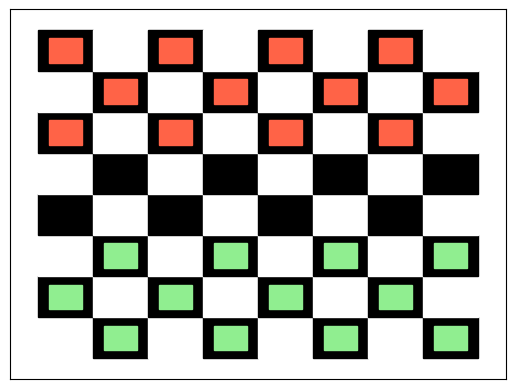

Making next move...
b'Valid move'


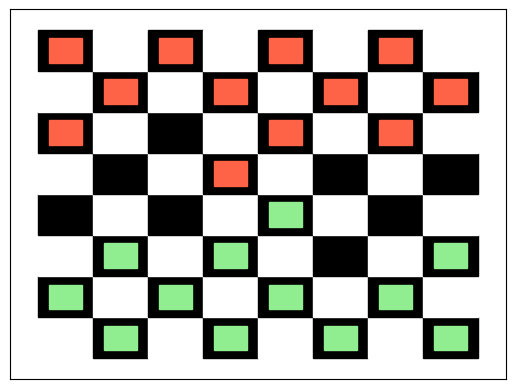

Making next move...
b'Valid move'


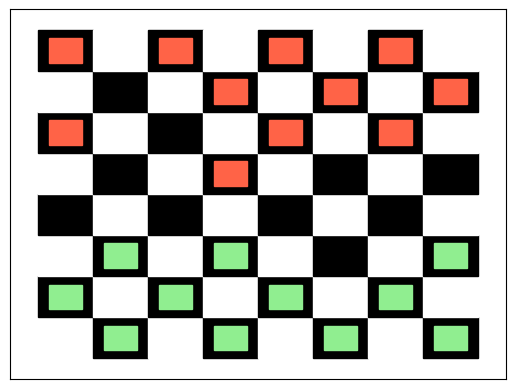

Making next move...
b'Valid move'


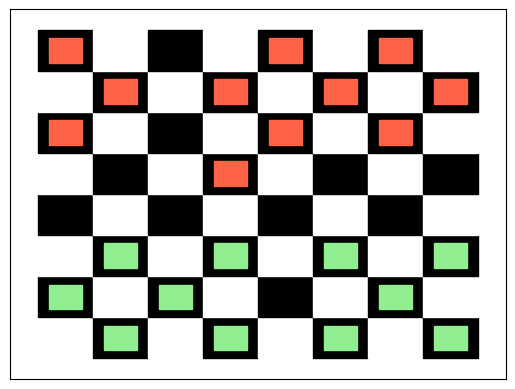

Making next move...
b'Valid move'


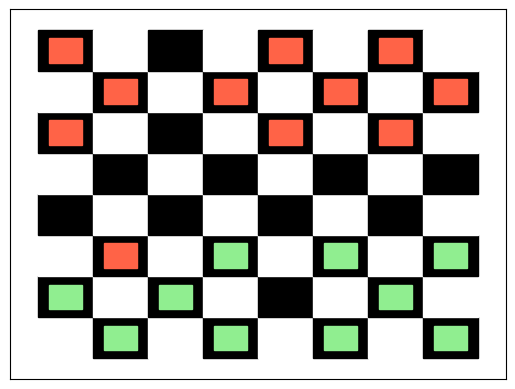

Making next move...
b'Valid move'


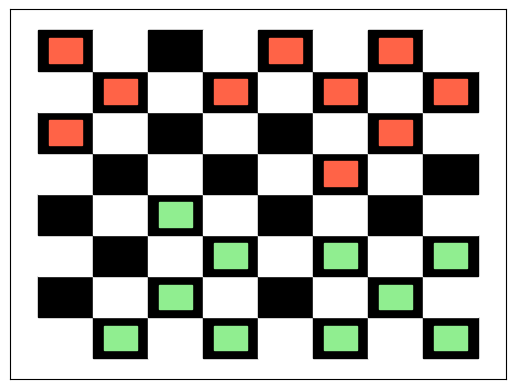

Making next move...
b'Valid move'


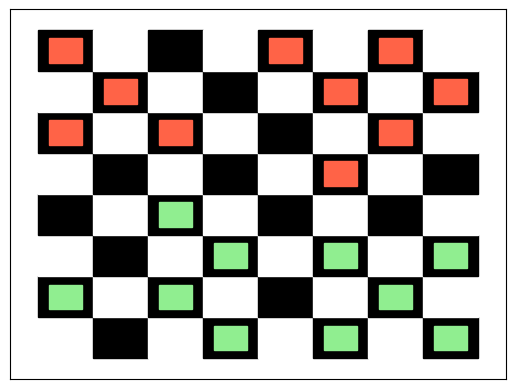

Making next move...
b'Valid move'


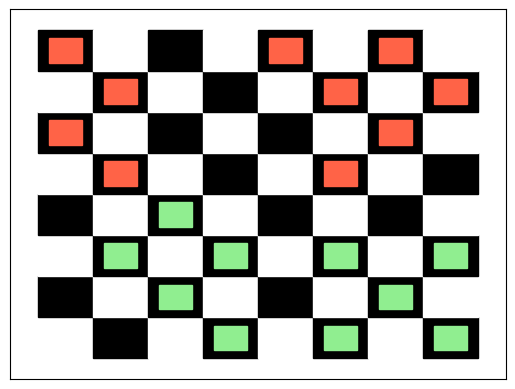

Making next move...
b'Valid move'


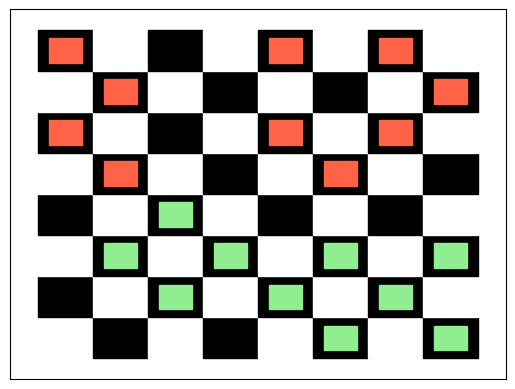

Making next move...
b'Valid move'


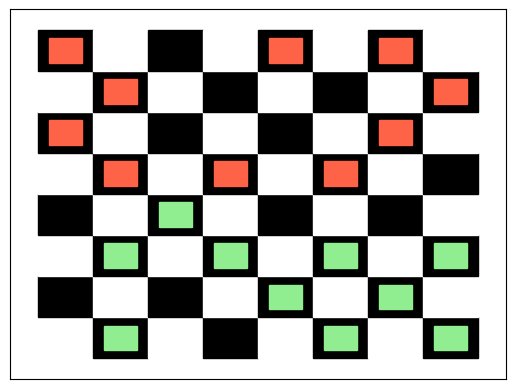

Making next move...
b'Valid move'


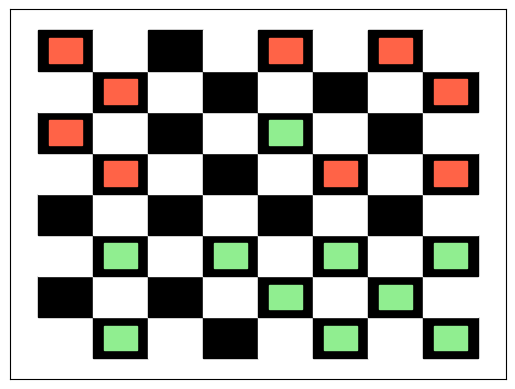

Making next move...
b'Valid move'


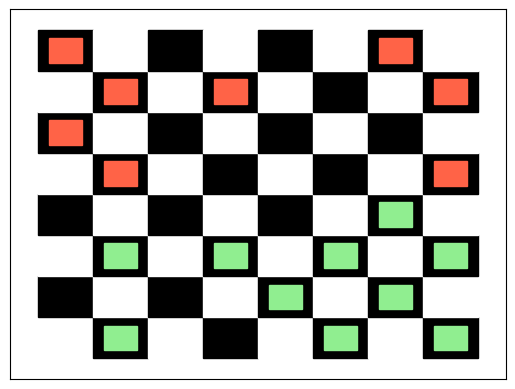

Making next move...
b'Valid move'


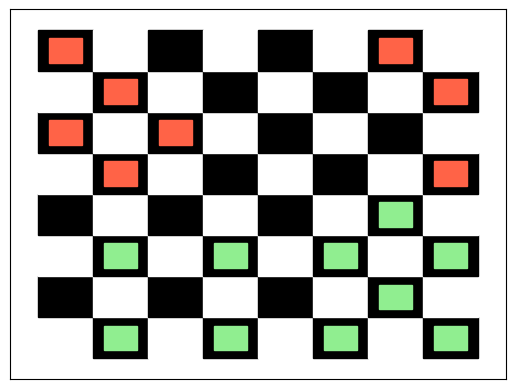

Making next move...
b'Valid move'


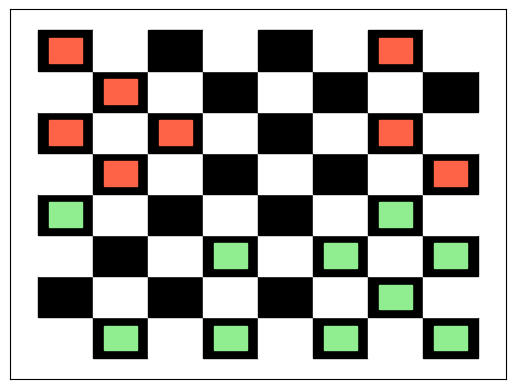

Making next move...
b'Valid move'


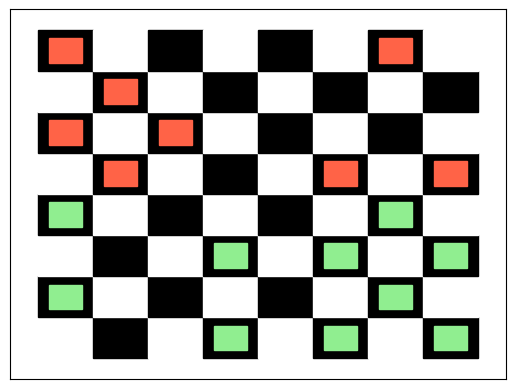

Making next move...
b'Valid move'


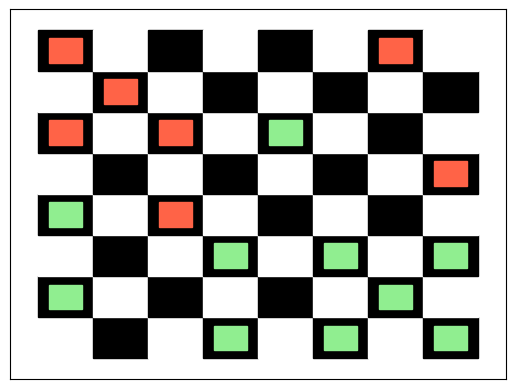

Making next move...
b'Valid move'


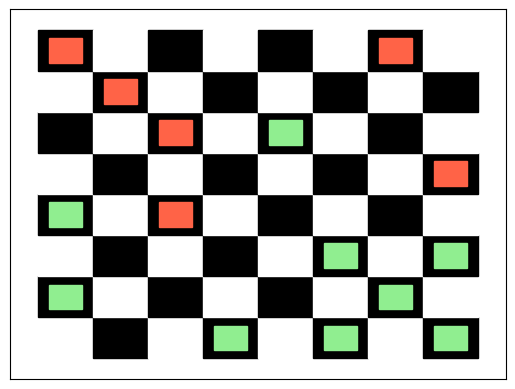

Making next move...
b'Valid move'


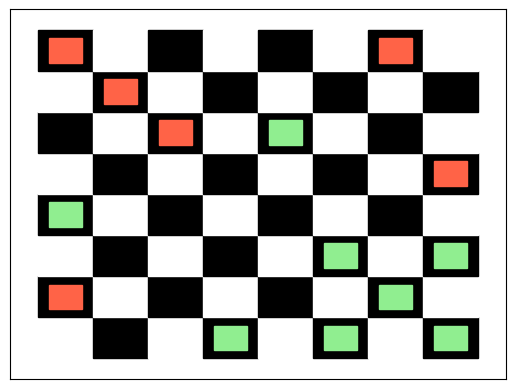

Making next move...
b'Valid move'


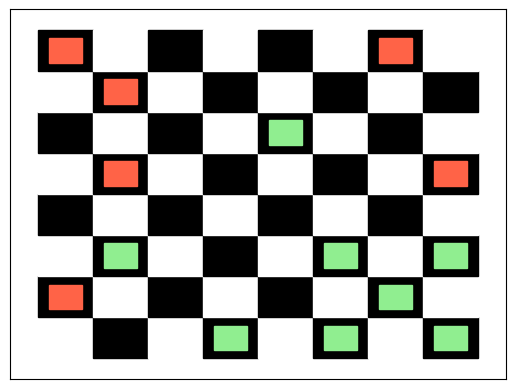

Making next move...
b'Valid move'


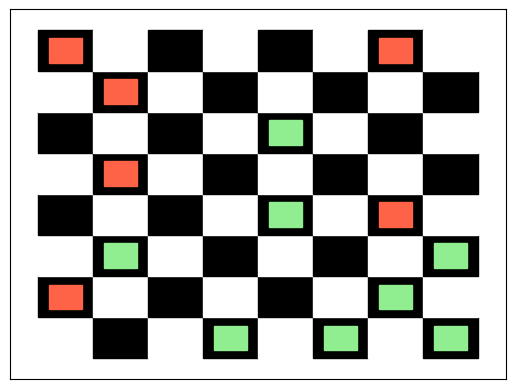

Making next move...
b'Valid move'


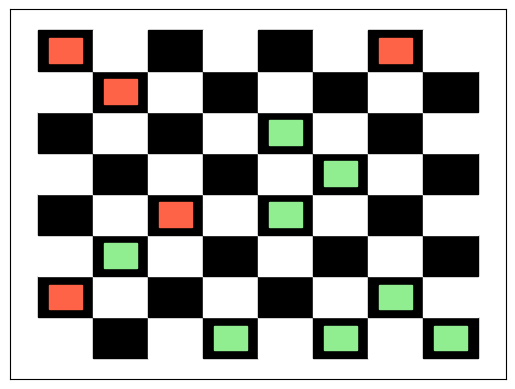

Making next move...
b'Valid move'


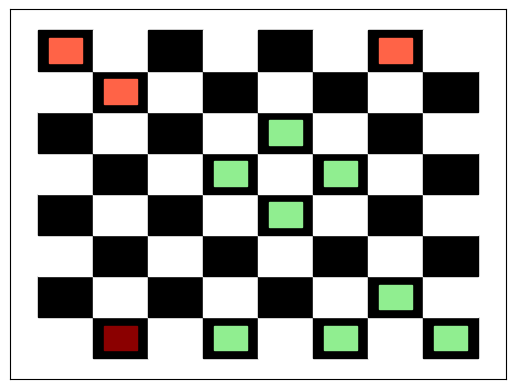

Making next move...
b'Valid move'


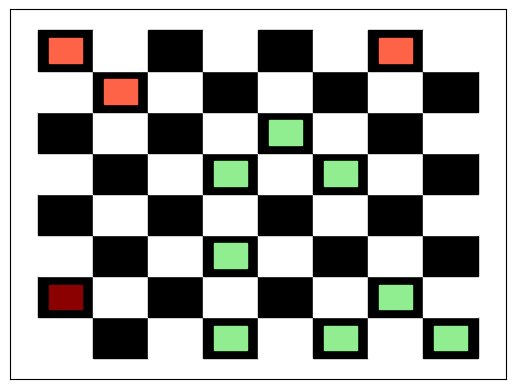

Making next move...
b'Valid move'


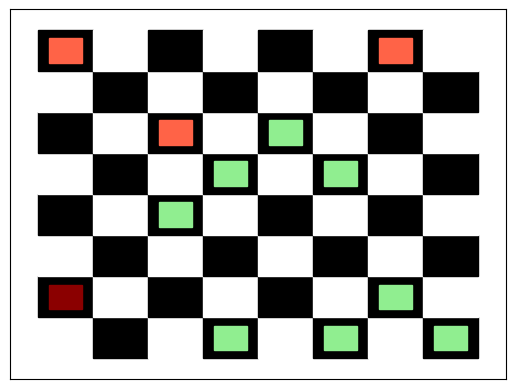

Making next move...
b'Valid move'


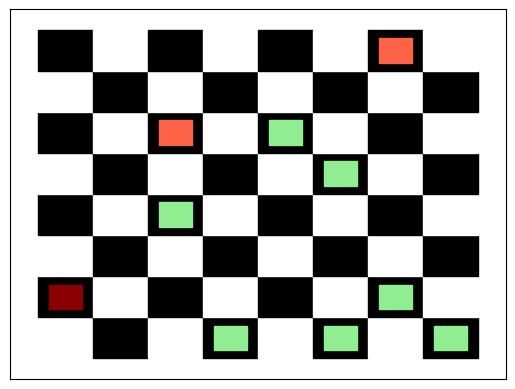

Making next move...
b'Valid move'


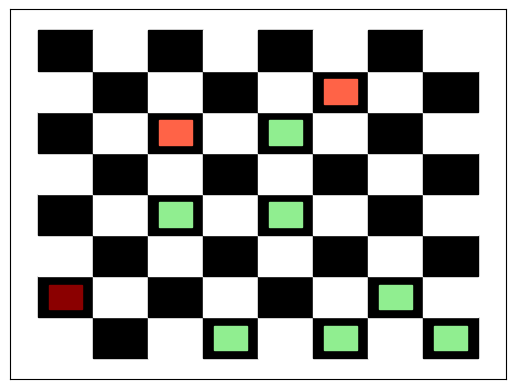

Making next move...
b'Valid move'


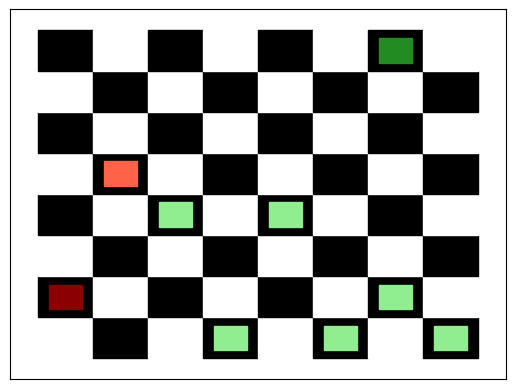

Making next move...
b'Valid move'


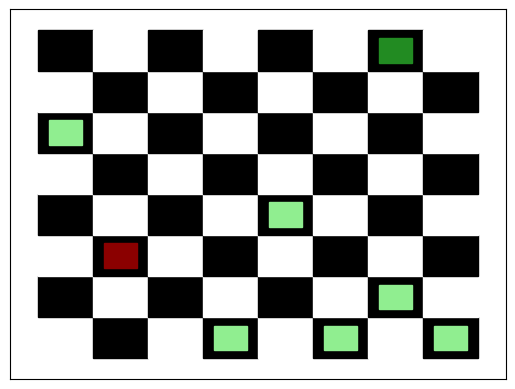

Making next move...
b'Valid move'


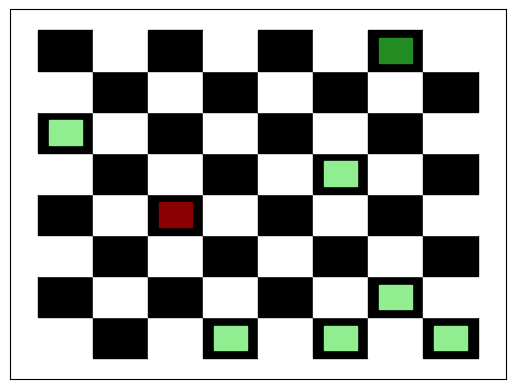

Making next move...
b'Valid move'


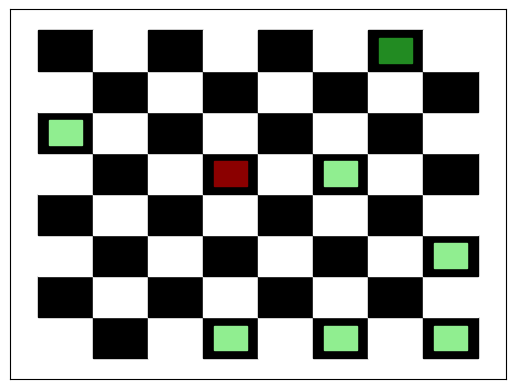

Making next move...
b'Valid move'


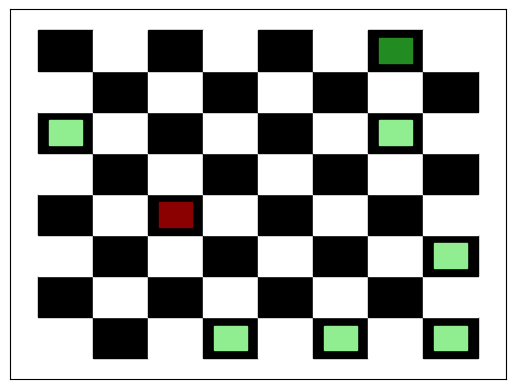

Making next move...
b'Valid move'


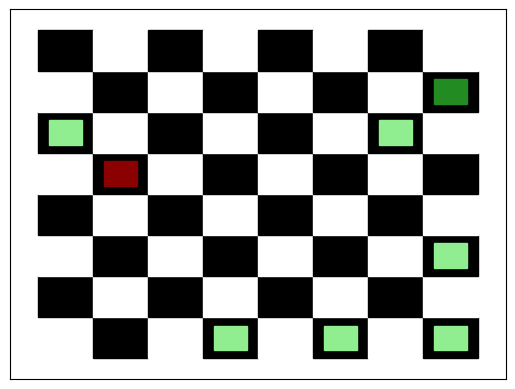

Making next move...
b'Valid move'


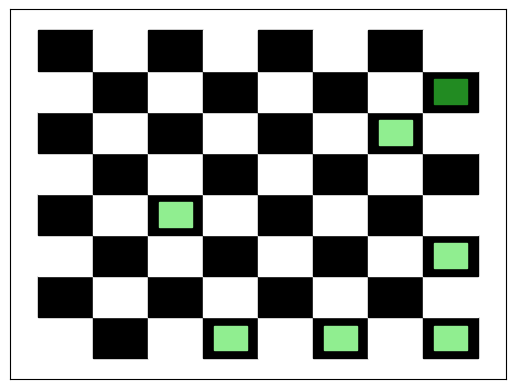

winner


In [213]:
game_loop(mcts_solver, Checkers, 'checkers', multi_player=False, id=None)


The server allows for invalid moves proof:
Making next move...
b'Valid move'
['_', 'x', '_', '_', '_', '_', '_', 'x']
['_', '_', '_', '_', '_', '_', '_', '_']
['_', 'x', '_', '_', '_', '_', '_', 'x']
['_', '_', 'o', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'x', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'o']
['_', '_', '_', '_', '_', '_', 'o', '_']

o moves

['_', 'x', '_', '_', '_', '_', '_', 'x']
['o', '_', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'x']
['_', '_', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', 'x', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'o']
['_', '_', '_', '_', '_', '_', 'o', '_']
Making next move...
b'Valid move'
['_', 'x', '_', '_', '_', '_', '_', 'x']
['o', '_', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'x']
['_', '_', '_', '_', '_', '_', 'x', '_']
['_', '_', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', '_']
['_', '_', '_', '_', '_', '_', '_', 'o']
['_', '_', '_', '_', '_', '_', 'o', '_']

